# Machine Learning exercise 3: Sine on ESP
2021 07 13 Maarten Pennings

I got a nice machine learning (ML) intro with the two previous exercises.
I wanted to make a next step, getting some ML running on a tiny device.

I found [Easy TinyML on ESP32 and Arduino](https://www.hackster.io/news/easy-tinyml-on-esp32-and-arduino-a9dbc509f26c), 
which replicates an exercise from the book [**TinyML, Machine Learning with TensorFlow Lite on Arduino and Ultra-Low-Power Microcontrollers** by Pete Warden and Daniel Situnayake](https://tinymlbook.com/). 
The book is an e-book, and you can get a sample of the first chapters. 
The website now only gives 2 chapters, but in the past that was six (you might still find that somewhere), 
which includes the important chapter _Chapter 4. The “Hello World” of TinyML: Building and Training a Model_.
This "Hello World" of ML is actually a network that "predicts" the _sin(x)_ given _x_.

It seems that this "Hello World" was even a standard example of [tensorflow](https://www.tensorflow.org/); 
it was on the tensorflow [github](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/micro) repo.
But as of June 25, 2021, the Tensorflow Lite for microcontrollers codebase has moved to a stand-alone 
[github repository](https://github.com/tensorflow/tflite-micro). We find it down deep [https://github.com/tensorflow/tflite-micro/tree/main/tensorflow/lite/micro/examples/hello_world](https://github.com/tensorflow/tflite-micro/tree/main/tensorflow/lite/micro/examples/hello_world).



## The project directory
Check my first exercise for details on replicating this project. Basically you need

- Python on your system
- Start with an empty project directory; then copy `requirements.txt`, `setup.bat`, `run.bat`, and `sin.ipynb` into it.
- Run `setup.bat` to create a virtual Python environment (in subdirectory `env` in the project directory).
- Note that several packages will be installed (including Jupyter), as listed in `requirements.txt`.
- Run `run.bat` to run the Jupyter server and client (web page in you browser).
- Open this file (`sin.ipynb`).


## Random

To get reproducible results, we seed the random generators.

In [1]:
import numpy as np
import tensorflow as tf

SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

## Try pi
For a network that computes sine, we don't need to download a data-set, we just use Python's `math` libary to get `sin()` data. Let's try it.

In [2]:
import math

xs=[]
ys=[]
for t in range(50+1) :
    x = 2*math.pi * t/50.0
    y = math.sin(x)
    xs.append(x)
    ys.append(y)

xs[25],ys[25]

(3.141592653589793, 1.2246467991473532e-16)

Looks good, for the item halfway the xs list, `x` is about π and `y` is about 0. Let's try to plot it.
The `'g.'` means green dots.

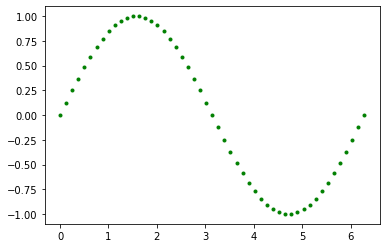

In [3]:
import matplotlib.pyplot as plt
plt.plot(xs,ys,'g.');

## Data set

Let's now be a bit more serious about creating a data set. We use numpy to work with vectors of floats.

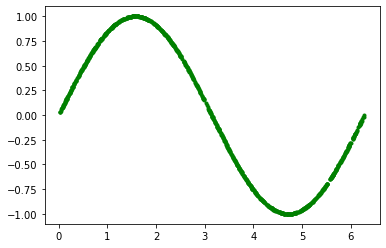

In [4]:
SAMPLES = 1000
x_values = np.random.uniform( low=0.0, high=2*math.pi, size=SAMPLES )
y_values = np.sin(x_values) # maps `sin()` to all elements of vector `x_values`
plt.plot(x_values,y_values,'g.');

Let's pretend our data is messy (by adding a random value from a normal distribution with mean 0 and variance 1).

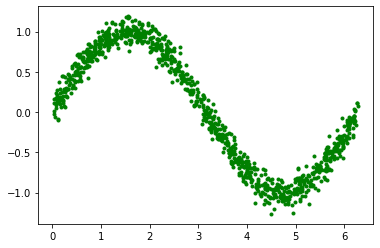

In [5]:
y_values += 0.1 * np.random.randn(SAMPLES)
plt.plot(x_values,y_values,'g.');

We need to split the data. For the first time, we will not split in _two_ parts (train and test) but in _three_: train, validate, and test.

We use the train set during the training phase to create the model. The validate set is also used during training to compute the _loss_: using fresh data (validate instead of train) gives a more reliable loss indicator. The test set is used when we believe the model is finished and we want to check the loss with fresh data.

In [6]:
FRACTION_TRAIN = 0.6
FRACTION_VALIDATE = 0.2

NUM_TRAIN = int(SAMPLES*FRACTION_TRAIN)
NUM_VALIDATE = int(SAMPLES*FRACTION_VALIDATE)
NUM_TEST = SAMPLES - NUM_TRAIN - NUM_VALIDATE

x_train,x_validate,x_test = np.split( x_values, [ NUM_TRAIN, NUM_TRAIN+NUM_VALIDATE ] )
y_train,y_validate,y_test = np.split( y_values, [ NUM_TRAIN, NUM_TRAIN+NUM_VALIDATE ] )

We can plot the three data sets; and by adding a `label` to each plot, we can add a `legend`.

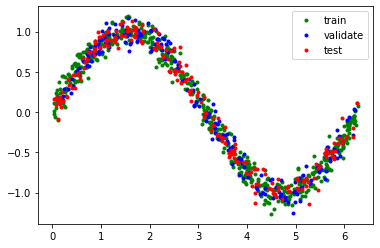

In [7]:
plt.plot(x_train,y_train,'g.',label='train')
plt.plot(x_validate,y_validate,'b.',label='validate')
plt.plot(x_test,y_test,'r.',label='test')
plt.legend();

## Setting up model 1

We start as before, with the `keras` interface of `tensorflow`. We create an (empty) neural network model; the `sequential` indicates that layers are in sequence. We will start with a simple model (`model_1`) and later make a more elaborate one.

In [8]:
model_1 = tf.keras.models.Sequential()

We built on top of the input layer, which is just a scalar, hence the `input_shape=(1,)`. A monochrome image of 10×10 would have `input_shape=(10,10)`, and a color one `input_shape=(10,10,3)`. 

The layer we create is `Dense`, which means that every neuron of this layer is connected to _all_ outputs of the previous. In our case the previous layer is the input layer with 1 value. If the input was really big, like an image, we would not use `Dense` but rather a "sweeping kernel", i.e. a convolution (`Conv2D`). The layer we create will have 9 outputs, so it will have 9 neurons each having the one input. 

In [9]:
model_1.add( tf.keras.layers.Dense(9, activation='relu', input_shape=(1,)) )

Recall that a neuron has weights for all its inputs, and one bias. Therefore the computation for neuron $i$ in layer 1 is as follows: its output $value_{1,i} = relu(weight_{1,i} \cdot value_0 + bias_{1,i})$. Here $value_0$ is the value of the previous layer, i.e. the input scalar, $weight_{1,i}$ is the weight of neuron $i$ in layer 1 and $bias_{1,i}$ is the bias of neuron $i$ in layer 1. Also note that $relu(x) = 0 \mathbin{\mbox{ max}} x$. See the network drawing below, which includes also the second layer.

We keep `model_1` simple, and in the second an last layer, we average the 9 neurons to one. So we will have 1 neuron, with 9 inputs: $value_2 = (\sum_{0\leq i<9} weight_{2,i} \cdot value_{1,i})+bias_2$. This will be the output of our network: we want a non-activated result and therefore we do not specify an `activation` parameter/function.

In [10]:
model_1.add( tf.keras.layers.Dense(1) )

Our is a small model, so we can easily draw it.

![model_1](model1.png)

Observe that the first layer has 9 neurons each with 1 weight and 1 bias (18 parameters) and the second layer has 1 neuron with 9 weights and 1 bias (10 parameters). In total 28 parameters.

Before we can start the learning process, we need to compile the model. We need to pass the _optimizer_; there are [multiple choices](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), we take the one named `'rmsprop'`. An optimizer tweaks the weights an biases during training. The optimizer function `rmsprop` is a good one for regression problems, i.e. problems where the output is a continuous value.

The optimizer optimizes a _loss_ function (also known as cost function). A loss function computes the "loss" ("distance") between the actual output of the network and the expected output. Also for the loss function there are [multiple choices](https://www.tensorflow.org/api_docs/python/tf/keras/losses), we take `'mse'`. This loss function  computes the _mean of squares of errors_ between predictions and the output.

The loss output is computed iteration after iteration. This data will be accumulated during training and returned by the training step (e.g. to draw a progress graph after training). Other data can also be accumulated, these functions need to be passed in the `metrics` list. We select `'mae'`, or mean _absolute_ error. 

In [11]:
model_1.compile( optimizer='rmsprop', loss='mse', metrics=['mae'] )

If we look at the diagram the first layer has 18 parameters and the second layer 10 parameters (total 28 parameters). let's check if the compiler agrees.

In [12]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 18        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 10        
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


That is a perfect match. Our mental model of the training model seems correct ;-)

## Training model 1

We will now train (`fit`) our simple model with the training data in several iterations, using the validation data to compute the loss. The first two parameters of the `fit()` call are the train  data (x and y), and the last parameter is the validation data.

I'm always a bit puzzled by the terms `epochs` and `batch_size`. Epoch is just a different word for "iteration", a loop over the complete train set (600 SAMPLES). However,  it is expensive to adapt the weights for each of these 600 SAMPLES, so the optimizer computes the average loss over a group of samples then adapts the weights ("backpropagation with gradient descent"). Parameter `batch_size` tells how many samples are grouped.

Note that higher `epochs` in general give better training results. However, at some moment the improvements start to be negligible . Also, the model might start to overfit the training data.

Parameter `batch_size` could be set to 1, this gives the slowest learning (but might work for this small network). Alternatively `batch_size` could be set to `len(x_train)` (600 in our case), fast, but we might not find the maximum fit (minimum loss).

We save the training data in `history_1`.

In [13]:
history_1 = model_1.fit(x_train, y_train, epochs=500, batch_size=16, validation_data=(x_validate, y_validate))

Epoch 1/500
38/38 [==============================] - 0s 3ms/step - loss: 7.2451 - mae: 2.1056 - val_loss: 5.2152 - val_mae: 1.7440
Epoch 2/500
38/38 [==============================] - 0s 838us/step - loss: 4.9575 - mae: 1.7634 - val_loss: 3.6290 - val_mae: 1.4962
Epoch 3/500
38/38 [==============================] - 0s 811us/step - loss: 3.3766 - mae: 1.4934 - val_loss: 2.4789 - val_mae: 1.2995
Epoch 4/500
38/38 [==============================] - 0s 811us/step - loss: 2.2868 - mae: 1.2786 - val_loss: 1.7312 - val_mae: 1.1432
Epoch 5/500
38/38 [==============================] - 0s 892us/step - loss: 1.5562 - mae: 1.0992 - val_loss: 1.2530 - val_mae: 1.0121
Epoch 6/500
38/38 [==============================] - 0s 811us/step - loss: 1.0866 - mae: 0.9498 - val_loss: 0.9412 - val_mae: 0.8940
Epoch 7/500
38/38 [==============================] - 0s 838us/step - loss: 0.8114 - mae: 0.8310 - val_loss: 0.7902 - val_mae: 0.8178
Epoch 8/500
38/38 [==============================] - 0s 799us/step - lo

38/38 [==============================] - 0s 784us/step - loss: 0.1391 - mae: 0.3213 - val_loss: 0.1312 - val_mae: 0.3090
Epoch 63/500
38/38 [==============================] - 0s 811us/step - loss: 0.1386 - mae: 0.3215 - val_loss: 0.1274 - val_mae: 0.3026
Epoch 64/500
38/38 [==============================] - 0s 811us/step - loss: 0.1378 - mae: 0.3198 - val_loss: 0.1270 - val_mae: 0.3031
Epoch 65/500
38/38 [==============================] - 0s 838us/step - loss: 0.1366 - mae: 0.3184 - val_loss: 0.1265 - val_mae: 0.3031
Epoch 66/500
38/38 [==============================] - 0s 784us/step - loss: 0.1359 - mae: 0.3178 - val_loss: 0.1247 - val_mae: 0.2997
Epoch 67/500
38/38 [==============================] - 0s 811us/step - loss: 0.1350 - mae: 0.3165 - val_loss: 0.1239 - val_mae: 0.2985
Epoch 68/500
38/38 [==============================] - 0s 870us/step - loss: 0.1334 - mae: 0.3142 - val_loss: 0.1245 - val_mae: 0.3001
Epoch 69/500
38/38 [==============================] - 0s 811us/step - loss:

38/38 [==============================] - 0s 811us/step - loss: 0.0829 - mae: 0.2442 - val_loss: 0.0776 - val_mae: 0.2333
Epoch 124/500
38/38 [==============================] - 0s 757us/step - loss: 0.0822 - mae: 0.2428 - val_loss: 0.0765 - val_mae: 0.2309
Epoch 125/500
38/38 [==============================] - 0s 784us/step - loss: 0.0816 - mae: 0.2413 - val_loss: 0.0779 - val_mae: 0.2346
Epoch 126/500
38/38 [==============================] - 0s 787us/step - loss: 0.0805 - mae: 0.2409 - val_loss: 0.0776 - val_mae: 0.2342
Epoch 127/500
38/38 [==============================] - 0s 811us/step - loss: 0.0799 - mae: 0.2395 - val_loss: 0.0743 - val_mae: 0.2272
Epoch 128/500
38/38 [==============================] - 0s 784us/step - loss: 0.0794 - mae: 0.2377 - val_loss: 0.0739 - val_mae: 0.2272
Epoch 129/500
38/38 [==============================] - 0s 784us/step - loss: 0.0782 - mae: 0.2365 - val_loss: 0.0730 - val_mae: 0.2250
Epoch 130/500
38/38 [==============================] - 0s 811us/step 

Epoch 184/500
38/38 [==============================] - 0s 757us/step - loss: 0.0489 - mae: 0.1738 - val_loss: 0.0451 - val_mae: 0.1703
Epoch 185/500
38/38 [==============================] - 0s 784us/step - loss: 0.0479 - mae: 0.1714 - val_loss: 0.0452 - val_mae: 0.1720
Epoch 186/500
38/38 [==============================] - 0s 811us/step - loss: 0.0479 - mae: 0.1706 - val_loss: 0.0457 - val_mae: 0.1743
Epoch 187/500
38/38 [==============================] - 0s 811us/step - loss: 0.0477 - mae: 0.1710 - val_loss: 0.0455 - val_mae: 0.1738
Epoch 188/500
38/38 [==============================] - ETA: 0s - loss: 0.0641 - mae: 0.204 - 0s 784us/step - loss: 0.0476 - mae: 0.1696 - val_loss: 0.0443 - val_mae: 0.1697
Epoch 189/500
38/38 [==============================] - 0s 784us/step - loss: 0.0470 - mae: 0.1687 - val_loss: 0.0458 - val_mae: 0.1750
Epoch 190/500
38/38 [==============================] - 0s 784us/step - loss: 0.0472 - mae: 0.1682 - val_loss: 0.0440 - val_mae: 0.1694
Epoch 191/500
38/

38/38 [==============================] - 0s 784us/step - loss: 0.0407 - mae: 0.1497 - val_loss: 0.0381 - val_mae: 0.1505
Epoch 245/500
38/38 [==============================] - 0s 811us/step - loss: 0.0411 - mae: 0.1508 - val_loss: 0.0378 - val_mae: 0.1527
Epoch 246/500
38/38 [==============================] - 0s 784us/step - loss: 0.0408 - mae: 0.1496 - val_loss: 0.0376 - val_mae: 0.1505
Epoch 247/500
38/38 [==============================] - 0s 784us/step - loss: 0.0409 - mae: 0.1495 - val_loss: 0.0373 - val_mae: 0.1508
Epoch 248/500
38/38 [==============================] - 0s 784us/step - loss: 0.0409 - mae: 0.1498 - val_loss: 0.0372 - val_mae: 0.1496
Epoch 249/500
38/38 [==============================] - 0s 811us/step - loss: 0.0406 - mae: 0.1491 - val_loss: 0.0372 - val_mae: 0.1499
Epoch 250/500
38/38 [==============================] - 0s 811us/step - loss: 0.0411 - mae: 0.1507 - val_loss: 0.0376 - val_mae: 0.1518
Epoch 251/500
38/38 [==============================] - 0s 784us/step 

38/38 [==============================] - 0s 757us/step - loss: 0.0404 - mae: 0.1477 - val_loss: 0.0378 - val_mae: 0.1503
Epoch 305/500
38/38 [==============================] - 0s 784us/step - loss: 0.0404 - mae: 0.1475 - val_loss: 0.0372 - val_mae: 0.1502
Epoch 306/500
38/38 [==============================] - 0s 757us/step - loss: 0.0405 - mae: 0.1485 - val_loss: 0.0379 - val_mae: 0.1505
Epoch 307/500
38/38 [==============================] - 0s 838us/step - loss: 0.0404 - mae: 0.1476 - val_loss: 0.0377 - val_mae: 0.1501
Epoch 308/500
38/38 [==============================] - 0s 811us/step - loss: 0.0404 - mae: 0.1468 - val_loss: 0.0371 - val_mae: 0.1500
Epoch 309/500
38/38 [==============================] - 0s 811us/step - loss: 0.0404 - mae: 0.1471 - val_loss: 0.0380 - val_mae: 0.1506
Epoch 310/500
38/38 [==============================] - 0s 811us/step - loss: 0.0403 - mae: 0.1473 - val_loss: 0.0374 - val_mae: 0.1516
Epoch 311/500
38/38 [==============================] - 0s 811us/step 

Epoch 365/500
38/38 [==============================] - 0s 784us/step - loss: 0.0404 - mae: 0.1474 - val_loss: 0.0370 - val_mae: 0.1510
Epoch 366/500
38/38 [==============================] - 0s 811us/step - loss: 0.0402 - mae: 0.1466 - val_loss: 0.0372 - val_mae: 0.1513
Epoch 367/500
38/38 [==============================] - 0s 811us/step - loss: 0.0403 - mae: 0.1476 - val_loss: 0.0376 - val_mae: 0.1532
Epoch 368/500
38/38 [==============================] - 0s 757us/step - loss: 0.0401 - mae: 0.1462 - val_loss: 0.0371 - val_mae: 0.1506
Epoch 369/500
38/38 [==============================] - 0s 811us/step - loss: 0.0405 - mae: 0.1476 - val_loss: 0.0371 - val_mae: 0.1504
Epoch 370/500
38/38 [==============================] - 0s 784us/step - loss: 0.0404 - mae: 0.1479 - val_loss: 0.0373 - val_mae: 0.1499
Epoch 371/500
38/38 [==============================] - 0s 784us/step - loss: 0.0404 - mae: 0.1477 - val_loss: 0.0373 - val_mae: 0.1496
Epoch 372/500
38/38 [==============================] - 

38/38 [==============================] - 0s 784us/step - loss: 0.0402 - mae: 0.1473 - val_loss: 0.0372 - val_mae: 0.1506
Epoch 426/500
38/38 [==============================] - 0s 784us/step - loss: 0.0401 - mae: 0.1465 - val_loss: 0.0371 - val_mae: 0.1506
Epoch 427/500
38/38 [==============================] - 0s 811us/step - loss: 0.0403 - mae: 0.1467 - val_loss: 0.0381 - val_mae: 0.1544
Epoch 428/500
38/38 [==============================] - 0s 757us/step - loss: 0.0402 - mae: 0.1461 - val_loss: 0.0391 - val_mae: 0.1563
Epoch 429/500
38/38 [==============================] - 0s 784us/step - loss: 0.0404 - mae: 0.1471 - val_loss: 0.0371 - val_mae: 0.1496
Epoch 430/500
38/38 [==============================] - 0s 757us/step - loss: 0.0402 - mae: 0.1462 - val_loss: 0.0379 - val_mae: 0.1539
Epoch 431/500
38/38 [==============================] - 0s 784us/step - loss: 0.0404 - mae: 0.1478 - val_loss: 0.0375 - val_mae: 0.1498
Epoch 432/500
38/38 [==============================] - 0s 757us/step 

Epoch 486/500
38/38 [==============================] - 0s 811us/step - loss: 0.0405 - mae: 0.1477 - val_loss: 0.0373 - val_mae: 0.1518
Epoch 487/500
38/38 [==============================] - 0s 757us/step - loss: 0.0406 - mae: 0.1477 - val_loss: 0.0371 - val_mae: 0.1505
Epoch 488/500
38/38 [==============================] - 0s 811us/step - loss: 0.0402 - mae: 0.1467 - val_loss: 0.0374 - val_mae: 0.1528
Epoch 489/500
38/38 [==============================] - 0s 804us/step - loss: 0.0402 - mae: 0.1469 - val_loss: 0.0370 - val_mae: 0.1496
Epoch 490/500
38/38 [==============================] - 0s 865us/step - loss: 0.0404 - mae: 0.1472 - val_loss: 0.0380 - val_mae: 0.1541
Epoch 491/500
38/38 [==============================] - 0s 811us/step - loss: 0.0404 - mae: 0.1475 - val_loss: 0.0371 - val_mae: 0.1497
Epoch 492/500
38/38 [==============================] - 0s 811us/step - loss: 0.0402 - mae: 0.1462 - val_loss: 0.0373 - val_mae: 0.1497
Epoch 493/500
38/38 [==============================] - 

We see that the `fit()` function prints the `loss` and the extra metric `mae` for the training data, but also for the validation data (`val_loss` and `val_mae`).

The loss goes down quickly: from over 7 to 1 in five steps; it seems to stablize around 0.04. Also the mean absolute error seems stuck at 0.15. An enourmous error when the output is between -1 and +1! The values of the validation data are not better.

## Analyzing model 1

The fun of the `history_1` is that we can use it to plot the progress. The key is `loss` for whatever loss function we chose, but there is also a key for every item we passed in for metrics (`mae` in our example). And since we passed validation data, we get this in two-fold; also prepended with `val_`:

In [14]:
for key in history_1.history: 
    print(key)

loss
mae
val_loss
val_mae


Let's plot the loss for the training and the validation data.

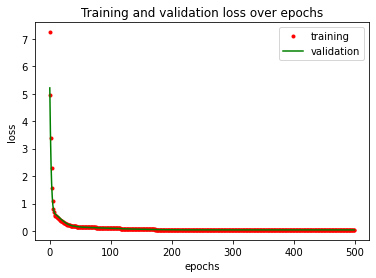

In [15]:
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(len(train_loss))
plt.plot( epochs, train_loss, 'r.', label="training" )
plt.plot( epochs, val_loss,   'g-', label="validation" )

plt.title('Training and validation loss over epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

The graph seems to show that after about 200 epochs, the loss does not change that much anymore. 
We can check that by dropping the first 200 epochs.

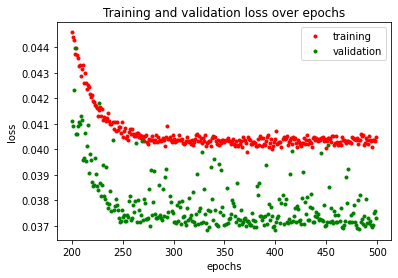

In [16]:
DROP = 200
plt.plot( epochs[DROP:], train_loss[DROP:], 'r.', label="training" )
plt.plot( epochs[DROP:], val_loss[DROP:],   'g.', label="validation" )

plt.title('Training and validation loss over epochs')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

This graph confirms that there is not much improvement after 250 epochs.

Lets look at the mean (absolute) error.

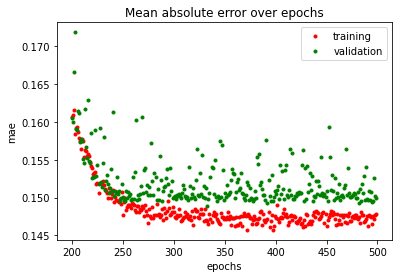

In [17]:
train_mae = history_1.history['mae']
val_mae = history_1.history['val_mae']
epochs = range(len(train_mae))
plt.plot( epochs[DROP:], train_mae[DROP:], 'r.', label="training" )
plt.plot( epochs[DROP:], val_mae[DROP:],   'g.', label="validation" )

plt.title('Mean absolute error over epochs')
plt.xlabel('epochs')
plt.ylabel('mae')
plt.legend();

The validation error is structurally higher than the training error. A hint for overfitting. 

More worrying, the error is large: around 0.15 (in a range of -1 to +1).

Let's check what the network predicts. Is that even looking remotely like a sine function?

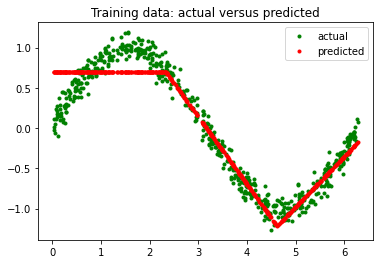

In [18]:
y_pred = model_1.predict(x_train)

plt.plot( x_train, y_train, 'g.', label='actual')
plt.plot( x_train, y_pred, 'r.', label='predicted')
plt.title('Training data: actual versus predicted')
plt.legend();

It is not bad at all, the sine function is approximated by three lines.
This gave my the impression that our model can implement a piece-wise liner curve.
There is an [intermezzo](piecewise-linear.ipynb) that explains this is true.

To make it better, we need to make our model more complex: add a layer.

## Replicating the prediction

Before we improve our model, let's try to replicate the computation of the model. We begin by checking the prediction for x=3.0. The model reports 0.14 as we see by calling `predict()`:

In [19]:
model_1.predict( [3.0] )

array([[0.14035952]], dtype=float32)

If we want to compute that ourselves, we need to know the weights after training. Let's confirm there are two layers in the model.

In [20]:
len(model_1.layers)

2

Let's get the "weights" (a list of weights and a list of  biases) of the first layer.

In [21]:
model_1.layers[0].weights

[<tf.Variable 'dense/kernel:0' shape=(1, 9) dtype=float32, numpy=
 array([[ 0.03466268, -0.09139192, -0.22791344, -0.05502343, -0.7224502 ,
          0.03779262,  0.30571744,  0.663836  , -0.4239734 ]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(9,) dtype=float32, numpy=
 array([-0.21815372,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.2449062 , -1.4121914 , -1.5453851 ,  0.        ], dtype=float32)>]

In the model (and hopefully yours if you used the same seed), the weights and biases are as follows (copied from the above output):

In [22]:
weights0 = np.array([ 0.03466268, -0.09139192, -0.22791344, -0.05502343, -0.7224502, 0.03779262, 0.30571744, 0.663836, -0.4239734 ])
biases0 = np.array([-0.21815372,  0.0, 0.0, 0.0, 0.0, -0.2449062, -1.4121914, -1.5453851,  0.0 ])

Let's multiply the `weights0` vector (1-dimensional numpy array) with our candidate input (3.0), and then add the `biases0` vector. The output is a vector.

In [23]:
weights0*3.0+biases0

array([-0.11416568, -0.27417576, -0.68374032, -0.16507029, -2.1673506 ,
       -0.13152834, -0.49503908,  0.4461229 , -1.2719202 ])

We still need to apply `relu()` to this vector. To implement `reul()`, we need to encode the `max` in numpy style.

In [24]:
def relu(x) : return np.where(x<0, 0.0, x)

value1 = relu(weights0*3.0+biases0)

The output (`value1`) is vector composed of the scalars $value_{1,i}$ in our drawing of the network. It has this value for input of 3.0.

In [25]:
value1

array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.4461229, 0.       ])

Let's check the parameters of the next layer.

In [26]:
model_1.layers[1].weights

[<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
 array([[ 0.09777404],
        [-0.02404529],
        [ 0.6676936 ],
        [-0.38391024],
        [ 0.3581022 ],
        [ 0.39436492],
        [ 4.7913165 ],
        [-1.2617588 ],
        [-0.23353118]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([0.703259], dtype=float32)>]

In the model, the weights and bias of layer 2 are as follows (copied from the above output).

In [27]:
weights1 = np.array( [0.09777404, -0.02404529, 0.6676936, -0.38391024, 0.3581022, 0.39436492, 4.7913165, -1.2617588 , -0.23353118])
biases1 = 0.703259

So computing the second layer gives the final output of the model.

In [28]:
sum(value1 * weights1) + biases1

0.14035950504348005

Bingo, same value as found at the start of this section.

## Setting up model 2

let us now try to make the model more powerful by adding an extra (dense) layer.

In [29]:
model_2 = tf.keras.models.Sequential()
model_2.add( tf.keras.layers.Dense(9, activation='relu', input_shape=(1,)) )
model_2.add( tf.keras.layers.Dense(9, activation='relu') )
model_2.add( tf.keras.layers.Dense(1) )
model_2.compile( optimizer='rmsprop', loss='mse', metrics=['mae'] )
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 9)                 18        
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 10        
Total params: 118
Trainable params: 118
Non-trainable params: 0
_________________________________________________________________


Let's train `model_2` with the same parameters as before.

In [30]:
history_2 = model_2.fit(x_train, y_train, epochs=500, batch_size=16, validation_data=(x_validate, y_validate))

Epoch 1/500
38/38 [==============================] - 0s 2ms/step - loss: 0.5637 - mae: 0.6749 - val_loss: 0.5445 - val_mae: 0.6644
Epoch 2/500
38/38 [==============================] - 0s 811us/step - loss: 0.4594 - mae: 0.5993 - val_loss: 0.4949 - val_mae: 0.6260
Epoch 3/500
38/38 [==============================] - 0s 838us/step - loss: 0.4054 - mae: 0.5539 - val_loss: 0.4469 - val_mae: 0.5855
Epoch 4/500
38/38 [==============================] - 0s 838us/step - loss: 0.3624 - mae: 0.5176 - val_loss: 0.4048 - val_mae: 0.5497
Epoch 5/500
38/38 [==============================] - 0s 866us/step - loss: 0.3257 - mae: 0.4867 - val_loss: 0.3616 - val_mae: 0.5186
Epoch 6/500
38/38 [==============================] - 0s 838us/step - loss: 0.2944 - mae: 0.4650 - val_loss: 0.3286 - val_mae: 0.4884
Epoch 7/500
38/38 [==============================] - 0s 838us/step - loss: 0.2652 - mae: 0.4413 - val_loss: 0.2873 - val_mae: 0.4617
Epoch 8/500
38/38 [==============================] - 0s 811us/step - lo

38/38 [==============================] - 0s 811us/step - loss: 0.0381 - mae: 0.1465 - val_loss: 0.0368 - val_mae: 0.1453
Epoch 63/500
38/38 [==============================] - 0s 838us/step - loss: 0.0373 - mae: 0.1463 - val_loss: 0.0325 - val_mae: 0.1355
Epoch 64/500
38/38 [==============================] - 0s 811us/step - loss: 0.0364 - mae: 0.1435 - val_loss: 0.0334 - val_mae: 0.1393
Epoch 65/500
38/38 [==============================] - 0s 811us/step - loss: 0.0353 - mae: 0.1427 - val_loss: 0.0320 - val_mae: 0.1345
Epoch 66/500
38/38 [==============================] - 0s 784us/step - loss: 0.0346 - mae: 0.1411 - val_loss: 0.0297 - val_mae: 0.1277
Epoch 67/500
38/38 [==============================] - 0s 811us/step - loss: 0.0338 - mae: 0.1378 - val_loss: 0.0305 - val_mae: 0.1325
Epoch 68/500
38/38 [==============================] - 0s 838us/step - loss: 0.0326 - mae: 0.1359 - val_loss: 0.0296 - val_mae: 0.1292
Epoch 69/500
38/38 [==============================] - 0s 838us/step - loss:

38/38 [==============================] - 0s 841us/step - loss: 0.0128 - mae: 0.0892 - val_loss: 0.0139 - val_mae: 0.0919
Epoch 124/500
38/38 [==============================] - 0s 865us/step - loss: 0.0128 - mae: 0.0895 - val_loss: 0.0121 - val_mae: 0.0874
Epoch 125/500
38/38 [==============================] - 0s 838us/step - loss: 0.0125 - mae: 0.0889 - val_loss: 0.0140 - val_mae: 0.0956
Epoch 126/500
38/38 [==============================] - 0s 811us/step - loss: 0.0124 - mae: 0.0887 - val_loss: 0.0155 - val_mae: 0.1010
Epoch 127/500
38/38 [==============================] - 0s 838us/step - loss: 0.0125 - mae: 0.0893 - val_loss: 0.0118 - val_mae: 0.0868
Epoch 128/500
38/38 [==============================] - 0s 784us/step - loss: 0.0126 - mae: 0.0885 - val_loss: 0.0142 - val_mae: 0.0963
Epoch 129/500
38/38 [==============================] - 0s 811us/step - loss: 0.0122 - mae: 0.0877 - val_loss: 0.0136 - val_mae: 0.0944
Epoch 130/500
38/38 [==============================] - 0s 811us/step 

Epoch 184/500
38/38 [==============================] - 0s 811us/step - loss: 0.0111 - mae: 0.0847 - val_loss: 0.0107 - val_mae: 0.0826
Epoch 185/500
38/38 [==============================] - 0s 801us/step - loss: 0.0113 - mae: 0.0846 - val_loss: 0.0127 - val_mae: 0.0915
Epoch 186/500
38/38 [==============================] - 0s 811us/step - loss: 0.0113 - mae: 0.0843 - val_loss: 0.0117 - val_mae: 0.0877
Epoch 187/500
38/38 [==============================] - 0s 784us/step - loss: 0.0109 - mae: 0.0837 - val_loss: 0.0108 - val_mae: 0.0845
Epoch 188/500
38/38 [==============================] - 0s 784us/step - loss: 0.0112 - mae: 0.0839 - val_loss: 0.0105 - val_mae: 0.0830
Epoch 189/500
38/38 [==============================] - 0s 784us/step - loss: 0.0111 - mae: 0.0836 - val_loss: 0.0129 - val_mae: 0.0917
Epoch 190/500
38/38 [==============================] - 0s 784us/step - loss: 0.0110 - mae: 0.0830 - val_loss: 0.0110 - val_mae: 0.0853
Epoch 191/500
38/38 [==============================] - 

Epoch 245/500
38/38 [==============================] - 0s 757us/step - loss: 0.0112 - mae: 0.0845 - val_loss: 0.0106 - val_mae: 0.0836
Epoch 246/500
38/38 [==============================] - 0s 801us/step - loss: 0.0108 - mae: 0.0826 - val_loss: 0.0109 - val_mae: 0.0840
Epoch 247/500
38/38 [==============================] - 0s 820us/step - loss: 0.0108 - mae: 0.0833 - val_loss: 0.0108 - val_mae: 0.0845
Epoch 248/500
38/38 [==============================] - 0s 793us/step - loss: 0.0112 - mae: 0.0844 - val_loss: 0.0106 - val_mae: 0.0820
Epoch 249/500
38/38 [==============================] - 0s 820us/step - loss: 0.0110 - mae: 0.0836 - val_loss: 0.0105 - val_mae: 0.0819
Epoch 250/500
38/38 [==============================] - 0s 792us/step - loss: 0.0114 - mae: 0.0848 - val_loss: 0.0119 - val_mae: 0.0884
Epoch 251/500
38/38 [==============================] - 0s 776us/step - loss: 0.0109 - mae: 0.0827 - val_loss: 0.0104 - val_mae: 0.0815
Epoch 252/500
38/38 [==============================] - 

Epoch 306/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0112 - mae: 0.0848 - val_loss: 0.0110 - val_mae: 0.0830
Epoch 307/500
38/38 [==============================] - 0s 973us/step - loss: 0.0109 - mae: 0.0830 - val_loss: 0.0107 - val_mae: 0.0821
Epoch 308/500
38/38 [==============================] - 0s 909us/step - loss: 0.0111 - mae: 0.0839 - val_loss: 0.0116 - val_mae: 0.0858
Epoch 309/500
38/38 [==============================] - 0s 871us/step - loss: 0.0112 - mae: 0.0849 - val_loss: 0.0108 - val_mae: 0.0823
Epoch 310/500
38/38 [==============================] - 0s 976us/step - loss: 0.0110 - mae: 0.0832 - val_loss: 0.0109 - val_mae: 0.0849
Epoch 311/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0108 - mae: 0.0836 - val_loss: 0.0105 - val_mae: 0.0830
Epoch 312/500
38/38 [==============================] - 0s 1ms/step - loss: 0.0108 - mae: 0.0830 - val_loss: 0.0114 - val_mae: 0.0869
Epoch 313/500
38/38 [==============================] - 0s 930

38/38 [==============================] - 0s 811us/step - loss: 0.0110 - mae: 0.0834 - val_loss: 0.0129 - val_mae: 0.0914
Epoch 367/500
38/38 [==============================] - 0s 865us/step - loss: 0.0110 - mae: 0.0831 - val_loss: 0.0114 - val_mae: 0.0871
Epoch 368/500
38/38 [==============================] - 0s 811us/step - loss: 0.0108 - mae: 0.0828 - val_loss: 0.0109 - val_mae: 0.0836
Epoch 369/500
38/38 [==============================] - 0s 838us/step - loss: 0.0110 - mae: 0.0844 - val_loss: 0.0129 - val_mae: 0.0918
Epoch 370/500
38/38 [==============================] - 0s 811us/step - loss: 0.0110 - mae: 0.0842 - val_loss: 0.0110 - val_mae: 0.0837
Epoch 371/500
38/38 [==============================] - 0s 784us/step - loss: 0.0111 - mae: 0.0845 - val_loss: 0.0105 - val_mae: 0.0828
Epoch 372/500
38/38 [==============================] - 0s 838us/step - loss: 0.0109 - mae: 0.0839 - val_loss: 0.0105 - val_mae: 0.0835
Epoch 373/500
38/38 [==============================] - 0s 838us/step 

Epoch 427/500
38/38 [==============================] - 0s 865us/step - loss: 0.0109 - mae: 0.0837 - val_loss: 0.0110 - val_mae: 0.0854
Epoch 428/500
38/38 [==============================] - 0s 838us/step - loss: 0.0109 - mae: 0.0827 - val_loss: 0.0120 - val_mae: 0.0879
Epoch 429/500
38/38 [==============================] - 0s 865us/step - loss: 0.0110 - mae: 0.0826 - val_loss: 0.0108 - val_mae: 0.0845
Epoch 430/500
38/38 [==============================] - 0s 838us/step - loss: 0.0107 - mae: 0.0824 - val_loss: 0.0109 - val_mae: 0.0852
Epoch 431/500
38/38 [==============================] - 0s 838us/step - loss: 0.0108 - mae: 0.0835 - val_loss: 0.0105 - val_mae: 0.0823
Epoch 432/500
38/38 [==============================] - 0s 865us/step - loss: 0.0111 - mae: 0.0836 - val_loss: 0.0105 - val_mae: 0.0826
Epoch 433/500
38/38 [==============================] - 0s 865us/step - loss: 0.0110 - mae: 0.0842 - val_loss: 0.0106 - val_mae: 0.0838
Epoch 434/500
38/38 [==============================] - 

Epoch 488/500
38/38 [==============================] - 0s 784us/step - loss: 0.0106 - mae: 0.0821 - val_loss: 0.0112 - val_mae: 0.0867
Epoch 489/500
38/38 [==============================] - 0s 811us/step - loss: 0.0108 - mae: 0.0825 - val_loss: 0.0103 - val_mae: 0.0818
Epoch 490/500
38/38 [==============================] - 0s 865us/step - loss: 0.0108 - mae: 0.0829 - val_loss: 0.0110 - val_mae: 0.0849
Epoch 491/500
38/38 [==============================] - 0s 919us/step - loss: 0.0107 - mae: 0.0828 - val_loss: 0.0123 - val_mae: 0.0895
Epoch 492/500
38/38 [==============================] - 0s 865us/step - loss: 0.0106 - mae: 0.0822 - val_loss: 0.0119 - val_mae: 0.0873
Epoch 493/500
38/38 [==============================] - 0s 838us/step - loss: 0.0110 - mae: 0.0840 - val_loss: 0.0107 - val_mae: 0.0841
Epoch 494/500
38/38 [==============================] - 0s 811us/step - loss: 0.0109 - mae: 0.0838 - val_loss: 0.0114 - val_mae: 0.0843
Epoch 495/500
38/38 [==============================] - 

If we compare the end-result of training `model_1` and `model_2` we see that the loss dropped a factor of 3 and the absolute error a factor of 2:

```
model_1: loss: 0.0405 - mae: 0.1478 - val_loss: 0.0373 - val_mae: 0.1499
model_2: loss: 0.0112 - mae: 0.0852 - val_loss: 0.0110 - val_mae: 0.0830
```

We plot `model_2`.

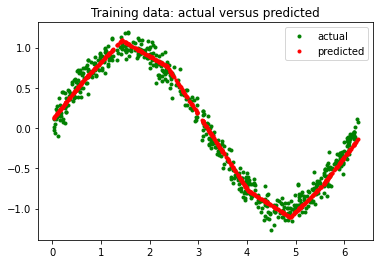

In [31]:
y_pred = model_2.predict(x_train)

plt.plot( x_train, y_train, 'g.', label='actual')
plt.plot( x_train, y_pred, 'r.', label='predicted')
plt.title('Training data: actual versus predicted')
plt.legend();

The graph is not totally convincing. We could expand our network: add more intermediate values (more than the 9 we have) or add an extra layer. We could also try longer training: more epochs or smaller batch size. 

But for now, we stick with these results, the goal is an ESP32 proof of concept.

## Testing

We are now going to use our _test_ data that we set aside. After that, we should not tweak parameters anymore: that would make the test data part of the training.

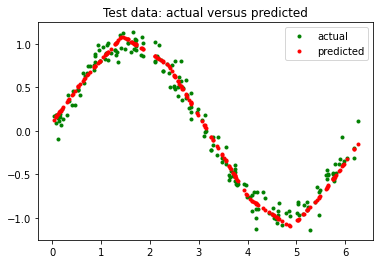

In [32]:
y_pred = model_2.predict(x_test)

plt.plot( x_test, y_test, 'g.', label='actual')
plt.plot( x_test, y_pred, 'r.', label='predicted')
plt.title('Test data: actual versus predicted')
plt.legend();

The graph for the test data looks similar to the one of the training data. What about the quantitative results?

In [33]:
results = model_2.evaluate(x_test, y_test)

7/7 [==============================] - 0s 834us/step - loss: 0.0115 - mae: 0.0844


The results are comparable.

```
model_2: loss: 0.0112 - mae: 0.0852 - val_loss: 0.0110 - val_mae: 0.0830
test   :                                  loss: 0.0115 -     mae: 0.0844
```

Good enough, we are here for a proof of concept of running TensorFlow on an ESP.
We save this model.

In [34]:
model_2.save('sine.h5')

## Conversion to TensorFlow lite

A TensorFlow _model_ contains a description of the layers: the number of layers, the number of "values" output by each layer, how the neurons are connected from input to output (e.g. "dense"), and how each neuron computes (the weights for the inputs, the bias, the activation function for the output). A model can be saved to disk, so that it can be loaded later.

A TensorFlow _interpreter_ takes a model and uses this as "instructions" for a computation: mapping an input to an output ("inference"). The standard interpreter is beefy; it assumes a PC to run on. The good news is that there is also a lite interpreter targeted for smaller platforms. The lite interpreter also needs a lite model.

This is were TensorFlow lite comes into play. It consists of two tools. The _converter_ converts a standard model into a lite one. The converter has options to reduce the size of the model (e.g. quantization). The resulting lite model can be saved to disk (in a portable format known as [FlatBuffers](https://google.github.io/flatbuffers/)with `.tflite` as extension). The second tool is an _interpreter_. It can load the lite model and use it to map input to output.

The key features of [TensorFlow lite](https://www.tensorflow.org/lite/guide) are latency (there's no round-trip to a server), privacy (no personal data leaves the device), connectivity (internet connectivity is not required), size (reduced model and binary size) and power consumption (efficient inference and a lack of network connections). But TensorFlow lite aims at mobile devices (Android, iOS). Where TensorFlow is around 20MB, TensorFlow lite has a footprint of 500kB.

There is support for even smaller platforms: [TensorFlow Lite for Microcontrollers](https://www.tensorflow.org/lite/microcontrollers). It is designed to run machine learning models on microcontrollers and other devices with only few kilobytes of memory. The core runtime just fits in 16 kB on an Arm Cortex M3 and can run many basic models. It doesn't require operating system support, any standard C or C++ libraries, support for floating point, or dynamic memory allocation. It is written in C++11 (with C APIs) and it does expect a 32 bit processor.

We begin by converting our TensorFlow (standard) `model_2` to TensorFlow lite. Fortunately, the convertor is part of the Python package.

In [35]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
model_2_lite = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\maarten\AppData\Local\Temp\tmpjgno7bd_\assets


We save the lite model (_default_ settings), which takes 2080 bytes.

In [36]:
open("sine.d.tflite", "wb").write(model_2_lite)

2080

We can do a similar thing but optimize for _size_.

In [37]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
converter.optimizations = [ tf.lite.Optimize.OPTIMIZE_FOR_SIZE ]
model_2_size = converter.convert()
open("sine.s.tflite", "wb").write(model_2_size)

INFO:tensorflow:Assets written to: C:\Users\maarten\AppData\Local\Temp\tmp_qbfhlse\assets


INFO:tensorflow:Assets written to: C:\Users\maarten\AppData\Local\Temp\tmp_qbfhlse\assets


2160

Hmm. Gets bigger...

I found a third method, somewhat more complicated.
We enable optimizations (which include quantization). 

In [38]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

We must also present the convertor with a representative data set; we use the `x_test` values for that. The form is a list generator (hence the `yield`) where each scalar is inside a two-dimensional array.

In [39]:
def data() :
  for x in x_test:
    yield [ np.array( x, dtype=np.float32, ndmin=2 ) ]

Then we can convert

In [40]:
converter.representative_dataset = data
model_2_liteq = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\maarten\AppData\Local\Temp\tmpsj394tpb\assets


INFO:tensorflow:Assets written to: C:\Users\maarten\AppData\Local\Temp\tmpsj394tpb\assets


We save the lite _quantized_ model, which takes 2472 bytes, surprisingly this is _more_ than unquantized...

In [41]:
open("sine.q.tflite", "wb").write(model_2_liteq)

2472

We see that the `h5` file is 15× as big as the `tflite` file (30 824 vs 2 080) and the "optimized" ones are actually bigger.

In [42]:
!dir  sine.h5  sine.*.tflite

 Volume in drive C has no label.
 Volume Serial Number is B2F0-CF6D

 Directory of C:\Repos\MachineLearning\sine

2021 08 10  19:53            30,824 sine.h5

 Directory of C:\Repos\MachineLearning\sine

2021 08 10  19:53             2,080 sine.d.tflite
2021 08 10  19:53             2,472 sine.q.tflite
2021 08 10  19:53             2,160 sine.s.tflite
               4 File(s)         37,536 bytes
               0 Dir(s)  264,433,176,576 bytes free


Probably, the bigger size of the quantized model is an artefact of how small the model already is. I continue with the smallest model.

## Interpreting the TensorFlow lite model

The lite model is harder to use than the standard model. We need to explicitly instantiate a lite interpreter and allocate memory for its tensors. 

In [43]:
interpreter = tf.lite.Interpreter('sine.d.tflite')
interpreter.allocate_tensors()

A next step that I do not fully understand is that we need to get a handle to the input and output values. This is obtained from the tensor details...

In [44]:
iinput = interpreter.get_input_details()[0]["index"]
ioutput = interpreter.get_output_details()[0]["index"]

We are now ready to use the interpreter for inference: write data to the input tensor, invoke the interpreter and read the data from the output tensor. We do this for every x value in `x_test`.

In [45]:
y_lite = []
for x in x_test:
    # Convert scalar x to a two-dimensional array
    xx = tf.convert_to_tensor( [[x]], dtype=np.float32 )
    # Write to input, infere, read output
    interpreter.set_tensor( iinput, xx )
    interpreter.invoke()
    yy = interpreter.get_tensor(ioutput)[0]
    # Append to y_lite
    y_lite.append( yy )

When we plot the standard model and the lite model, we hardly see any difference.

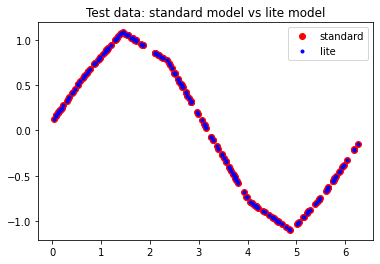

In [46]:
plt.plot( x_test, y_pred, 'ro', label='standard')
plt.plot( x_test, y_lite, 'b.', label='lite')
plt.title('Test data: standard model vs lite model')
plt.legend();

To convince ourselves that there is a difference, we compute it.

In [47]:
error = 0
for i in range(len(x_test)) :
    y1 = y_pred[i][0]
    y2 = y_lite[i][0]
    delta = abs(y1-y2)
    error += delta

print(error)

7.987022399902344e-06


## Saving FlatBuffer as C-array

The next step is to create a C program that includes the interpreter and the model and that is able to take an input and run an inference on that. We first look at "including" the model. For this we convert the FlatBuffer to a C-array (since we typically don't have a filesystem on small CPUs).

If you are using linux, you can run the standard `xxd` tool to convert the FlatBuffer to a c-array (that is the meaning of the `-i` argument).

```
  xxd  -i  sine.d.tflite  >  sine.h
```

Unfortunately, I develop on Windows, so there is no `xxd`. 
I wrote a Python function that does the same.

In [48]:
import datetime 
def bytes2carray(b1,dir=".",name="model") :
    # b1 = b'\x1c\x00\x00...'
    b2 = [ f"0x{byte:02X}" for byte in b1 ]
    # b2 = ['0x1C', '0x00', '0x00', ...]
    b3 = ', '.join( b2 )
    # b3 = '0x1C, 0x00, 0x00, ...'
    n = len("0x##, ")*8
    b4 = [ b3[i:i+n] for i in range(0,len(b3),n)]
    # b4 = [ '0x1C, 0x00, 0x00, <5more>', '0x14, 0x00, 0x20, <5more>', ...]
    b5 = '\n    '.join(b4)
    # b5 = [ '0x1C, 0x00, 0x00, <5more>\n    ', '0x14, 0x00, 0x20, <5more>\n    ', ...]
    pre0 = f"// {name}.h - TensorFlow lite model - {datetime.datetime.now()}"
    pre1 = f"#define MODEL_ALIGN __attribute__((aligned(4)))"
    pre2 = f"const unsigned char {name}_data[] MODEL_ALIGN = {{"
    post1= f"}};"
    post2= f"unsigned int {name}_len = {len(b1)};"
    b6 = f"{pre0}\n\n{pre1}\n\n{pre2}\n    {b5}\n{post1}\n\n{post2}"
    return open( f"{dir}/{name}.h", "w").write(b6)

In order to save our FlatBuffer to a C header file om subdirectory `sine32`, we just call this function.

In [49]:
bytes2carray(model_2_lite,"sine32");

The generated file `model.h`, containing a c-array of the FlatBuffer, is now created in the subdirectory `sine32`. This directory also contains our sketch `sine32.ino`.

In [50]:
!dir  sine32

 Volume in drive C has no label.
 Volume Serial Number is B2F0-CF6D

 Directory of C:\Repos\MachineLearning\sine\sine32

2021 08 10  19:06    <DIR>          .
2021 08 10  19:06    <DIR>          ..
2021 08 10  19:53            14,242 model.h
2021 08 10  19:06             1,015 sine32.ino
               2 File(s)         15,257 bytes
               2 Dir(s)  264,433,176,576 bytes free


Let's check the start and end of this file.

In [51]:
print(open("sine32/model.h","r").read()[:532], "\n    ...\n", open("sine32/model.h","r").read()[-401:])

// model.h - TensorFlow lite model - 2021-08-10 19:53:30.702120

#define MODEL_ALIGN __attribute__((aligned(4)))

const unsigned char model_data[] MODEL_ALIGN = {
    0x1C, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4C, 0x33, 
    0x14, 0x00, 0x20, 0x00, 0x04, 0x00, 0x08, 0x00, 
    0x0C, 0x00, 0x10, 0x00, 0x14, 0x00, 0x00, 0x00, 
    0x18, 0x00, 0x1C, 0x00, 0x14, 0x00, 0x00, 0x00, 
    0x03, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00, 
    0x1C, 0x00, 0x00, 0x00, 0xA8, 0x00, 0x00, 0x00, 
    0x1C, 0x00, 0x00, 0x00, 0x50, 0x00, 0x00, 0x00, 
    ...
   0x02, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 
    0x01, 0x00, 0x00, 0x00, 0x02, 0x00, 0x00, 0x00, 
    0xFF, 0xFF, 0xFF, 0xFF, 0x01, 0x00, 0x00, 0x00, 
    0x0D, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6E, 0x73, 
    0x65, 0x5F, 0x32, 0x5F, 0x69, 0x6E, 0x70, 0x75, 
    0x74, 0x00, 0x00, 0x00, 0xFC, 0xFF, 0xFF, 0xFF, 
    0x04, 0x00, 0x04, 0x00, 0x04, 0x00, 0x00, 0x00
};

unsigned int model_len = 2080;


## Deploy on ESP32

Final step is to run this tensorFlow lite model on an ESP32. Unfortunately, the ESp32 is not listed as a supported board on [TensorFlow Lite for microcontrollers](https://www.tensorflow.org/lite/microcontrollers). Well, it is, but using the using _ESP IDF_ and not _Arduino IDE_. But [Easy TinyML on ESP32 and Arduino](https://www.hackster.io/news/easy-tinyml-on-esp32-and-arduino-a9dbc509f26c) explains how to use the Arduino IDE, and that is my goal in this section.

To get started with Arduino IDE and ESP32 follow some 
[tutorial](https://randomnerdtutorials.com/installing-the-esp32-board-in-arduino-ide-windows-instructions/).
In a nutshell:
    
 - Download and install the Arduino IDE 
   [https://www.arduino.cc/en/software](https://www.arduino.cc/en/software).
   I have version 1.8.13.
 - Add `https://dl.espressif.com/dl/package_esp32_index.json` to "Additional Boards Manager URLs"
   in the IDE under Filer > Preferences (if you already have some, separate the URLs with comma's).
 - In Tools > Board (manager) find `esp32` and press "Install".
   I have version 1.0.6.
 - You might need to install a USB-to-serial driver so that your PC can communicate with the ESP board.
   My ESP board has a "Silicon Labs CP210x USB to UART Bridge", check under "Device Manager".

To confirm everything is working, I tried a small program.
 - My ESP board is an unknown chinese [clone](https://www.aliexpress.com/item/32885906652.html) 
   so I selected under Tools > Board the "ESP32 Dev Module" as board.
 - In Tools > Port select the com port previously found under "Device Manager".
 - I used below program, and compiled an uploaded via Sketch > Upload.
   ```c
   int count;

   void setup() {
     Serial.begin(115200);
     while( !Serial ) ; //skip
     Serial.printf( "Count\n");
     count = 0;
   }

   void loop() {
     Serial.printf( "count=%d\n", count++);
     delay(1000);
   }
   ```
 - While uploading, I needed to press and hold the "IO0" (aka "FLASH" or "BOOT") 
   button on the board to bring the board in flash mode.


This is what I checked for the build and run cycle.

 - Open the terminal via Tools > Serial Monitor and check the output.
   ```text
   Count
   count=0
   count=1
   count=2
   count=3
   count=4
   count=5
   count=6
   count=7
   ```
   
 - The build is successful, and gives these statistics.
   ```text
   Sketch uses 204634 bytes (15%) of program storage space. Maximum is 1310720 bytes.
   Global variables use 13416 bytes (4%) of dynamic memory, leaving 314264 bytes for local variables. Maximum is 327680 bytes.
   ```
   They make sense:

In [52]:
sketch_avail=1310720
vars_avail=327680

sketch0=204634
vars0=13416

print( f"Sketch {100*sketch0/sketch_avail:.2f}%" )
print( f"Sketch {100*vars0/vars_avail:.2f}%" )

Sketch 15.61%
Sketch 4.09%


Next we add a library to our Arduino setup. This library makes it easy to use TensorFlow Lite on the ESP32.
 - Download the zip from [EloquentTinyML](https://github.com/eloquentarduino/EloquentTinyML) 
   by pressing the green button labeled "Code".
 - Unzip it in your Arduino libraries folder. 
   For me that is `C:\Users\maarten\Documents\Arduino\libraries`
 - Optionally rename the top-level directory, and ensure the unzip didn't add an extra level.
   For me the core header file is here `C:\Users\maarten\Documents\Arduino\libraries\EloquentTinyML\src\EloquentTinyML.h`.

Let's now use this library to execute inferences using the sinus model.
The Arduino application is in the directory [sine32](sine32).
This directory contains the generated model (`model.h`) and the sketch (`sine32.ino`), which is also listed below.

```c
#include <EloquentTinyML.h> // From https://github.com/eloquentarduino/EloquentTinyML
#include "model.h"          // From https://github.com/maarten-pennings/MachineLearning/blob/main/sine/sine.ipynb

#define NUMBER_OF_INPUTS  1
#define NUMBER_OF_OUTPUTS 1
#define TENSOR_ARENA_SIZE 2*1024 // Trial and error

Eloquent::TinyML::TfLite<
    NUMBER_OF_INPUTS, 
    NUMBER_OF_OUTPUTS, 
    TENSOR_ARENA_SIZE
> ml;

void setup() {
    Serial.begin(115200);
    while( !Serial ) ; //skip
    Serial.printf( "Sine\n");
    ml.begin(model_data);
}

void loop() {
    float input[NUMBER_OF_INPUTS], output[NUMBER_OF_OUTPUTS];
    uint32_t time0, time1;
    float x, y1, y2;
    
    x  = 2 * 3.14159 * random(1000+1) / 1000;
    y1 = sin(x);

    input[0] = x;
    time0  = micros();
        ml.predict(input,output);
    time1 = micros();
    y2 = output[0];
    
    Serial.printf("x=%f, sine=%+f, model=%+f, error=%+f, time=%d\n",x,y1,y2,y2-y1,time1-time0);
    
    delay(1000);
}
```

The output of the program is as expected.

```text
Sine
x=3.342652, sine=-0.199707, model=-0.146198, error=+0.053509, time=83
x=2.934245, sine=+0.205865, model=+0.232621, error=+0.026756, time=56
x=2.959378, sine=+0.181208, model=+0.209309, error=+0.028101, time=48
x=5.661145, sine=-0.582694, model=-0.623821, error=-0.041127, time=52
x=1.998051, sine=+0.910107, model=+0.894373, error=-0.015734, time=47
x=4.687252, sine=-0.999684, model=-1.029061, error=-0.029377, time=48
x=4.461058, sine=-0.968582, model=-0.943305, error=+0.025277, time=52
x=5.705127, sine=-0.546399, model=-0.589319, error=-0.042920, time=48
x=0.835663, sine=+0.741741, model=+0.715530, error=-0.026211, time=50
x=1.495397, sine=+0.997159, model=+1.069428, error=+0.072269, time=47
x=5.610880, sine=-0.622791, model=-0.663252, error=-0.040460, time=48
x=4.398226, sine=-0.951055, model=-0.919484, error=+0.031571, time=51
x=3.939554, sine=-0.715934, model=-0.699858, error=+0.016077, time=47
x=5.390968, sine=-0.778465, model=-0.807471, error=-0.029006, time=51
x=1.156105, sine=+0.915241, model=+0.917457, error=+0.002216, time=46
x=0.339292, sine=+0.332819, model=+0.361712, error=+0.028893, time=44
x=2.255662, sine=+0.774504, model=+0.804657, error=+0.030153, time=46
x=2.463006, sine=+0.627693, model=+0.669720, error=+0.042027, time=48
x=2.695484, sine=+0.431458, model=+0.454085, error=+0.022627, time=52
x=0.056549, sine=+0.056518, model=+0.147189, error=+0.090671, time=44
x=3.518581, sine=-0.368122, model=-0.309382, error=+0.058739, time=48
x=2.538405, sine=+0.567271, model=+0.599785, error=+0.032514, time=51
x=2.299644, sine=+0.745942, model=+0.789340, error=+0.043398, time=46
x=3.424333, sine=-0.278988, model=-0.221962, error=+0.057026, time=48
x=0.226194, sine=+0.224271, model=+0.275903, error=+0.051632, time=48
x=1.011592, sine=+0.847678, model=+0.826392, error=-0.021285, time=47
x=1.891237, sine=+0.949097, model=+0.931572, error=-0.017525, time=46
x=2.965661, sine=+0.175025, model=+0.203481, error=+0.028456, time=48
x=5.177341, sine=-0.893843, model=-0.935770, error=-0.041927, time=51
x=1.602211, sine=+0.999507, model=+1.032229, error=+0.032722, time=47
x=4.549022, sine=-0.986685, model=-0.976655, error=+0.010031, time=48
x=2.676635, sine=+0.448385, model=+0.471569, error=+0.023184, time=51
x=4.021235, sine=-0.770511, model=-0.775621, error=-0.005110, time=47
x=1.972919, sine=+0.920232, model=+0.903126, error=-0.017107, time=50
x=6.094685, sine=-0.187386, model=-0.283726, error=-0.096339, time=48
```

Things to note
 - the greatest (absolute) error is around 0.1 but can be 10× smaller
 - this seems in line with the MAE we found (0.0844)
 - the inference time is about 50us

When we compile that, we get this summary.

```text
Sketch uses 402406 bytes (30%) of program storage space. Maximum is 1310720 bytes.
Global variables use 21640 bytes (6%) of dynamic memory, leaving 306040 bytes for local variables. Maximum is 327680 bytes.
```

When we check the percentages they make sense:

In [53]:
sketch1=402406
vars1=21640

print( f"Sketch {100*sketch1/sketch_avail:.2f}%" )
print( f"Sketch {100*vars1/vars_avail:.2f}%" )

Sketch 30.70%
Sketch 6.60%


We deliberately used `Serial` in the "count" sketch: "sine32" also uses it. We did not use any other fancy stuff (eg LEDs), beacuse "sine32" doesn't. This allows us to use "count" as a reference for 'sine32":

In [54]:
print( f"ESP32  {'count':>8} {'sinus':>8} {'grow':>8}" )
print( f"Sketch {sketch0:8} {sketch1:8} {sketch1-sketch0:8}" )
print( f"Vars   {vars0:8} {vars1:8} {vars1-vars0:8}" )

ESP32     count    sinus     grow
Sketch   204634   402406   197772
Vars      13416    21640     8224


The grow, especially for the code, is much more than I expected. Still very OK for the ESP32. Especially, because the model is only 2k, the 197k is nearly completely for the interpreter, which is fixed in size.

## Deploy on ESP8266

This was so easy, and the ESP8266 is in the same family as the ESP32, so in this final chapter I want to replicate the ESP32 experiment on the ESP8266. 

 - I used some [clone](https://www.aliexpress.com/item/32812846719.html).
 - Arduino File > Preferences needs `https://arduino.esp8266.com/stable/package_esp8266com_index.json`.
 - I installed `esp8266` version 3.0.2.
 - I installed the driver `USB-SERIAL CH340`.
 - I selected under Tools > Board the "NodeMCU 1.0 (ESP-12E Module)" as board.
 
The "count" program compiles and runs fine. These are the statistics.

```text
Sketch uses 265257 bytes (25%) of program storage space. Maximum is 1044464 bytes.
Global variables use 28012 bytes (34%) of dynamic memory, leaving 53908 bytes for local variables. Maximum is 81920 bytes.
```

and they make sense:

In [55]:
esp8266_sketch_avail=1044464
esp8266_vars_avail=81920

esp8266_sketch0=265257
esp8266_vars0=28012

print( f"Sketch {100*esp8266_sketch0/esp8266_sketch_avail:.2f}%" )
print( f"Sketch {100*esp8266_vars0/esp8266_vars_avail:.2f}%" )

Sketch 25.40%
Sketch 34.19%


Next step is to run the "sinus" program. Also this ony compiles and runs fine.

```
Sine
x=4.819199, sine=-0.994301, model=-1.079085, error=-0.084784, time=450
x=6.038136, sine=-0.242604, model=-0.328086, error=-0.085482, time=320
x=0.628318, sine=+0.587785, model=+0.581002, error=-0.006783, time=275
x=1.231503, sine=+0.942990, model=+0.964969, error=+0.021979, time=260
x=0.628318, sine=+0.587785, model=+0.581002, error=-0.006783, time=280
x=2.205396, sine=+0.805309, model=+0.822163, error=+0.016854, time=267
x=2.463006, sine=+0.627693, model=+0.669720, error=+0.042027, time=293
x=5.309287, sine=-0.827083, model=-0.856526, error=-0.029443, time=273
x=1.369733, sine=+0.979855, model=+1.052075, error=+0.072220, time=264
x=1.275486, sine=+0.956712, model=+0.992685, error=+0.035973, time=260
x=6.063269, sine=-0.218148, model=-0.308370, error=-0.090222, time=293
```

The inference time is around 280us. This is puzzling, because that is nearly 6 times as slow as the ESP32. Yes, that one has two cores (would they both be used?) and runs at 160MHz instead of 80MHz, but that only explains 4× (best case).

The published compile statistics are as follows.

```text
Sketch uses 386353 bytes (36%) of program storage space. Maximum is 1044464 bytes.
Global variables use 47376 bytes (57%) of dynamic memory, leaving 34544 bytes for local variables. Maximum is 81920 bytes.
```

And they make sense.

In [56]:
esp8266_sketch1=386353
esp8266_vars1=47376

print( f"Sketch {100*esp8266_sketch1/esp8266_sketch_avail:.2f}%" )
print( f"Sketch {100*esp8266_vars1/esp8266_vars_avail:.2f}%" )

Sketch 36.99%
Sketch 57.83%


Let's also investigate the grow when moving from "count" to "sinus" on the ESP8266.

In [57]:
print( f"ESP8266 {'count':>8} {'sinus':>8} {'grow':>8}" )
print( f"Sketch  {esp8266_sketch0:8} {esp8266_sketch1:8} {esp8266_sketch1-esp8266_sketch0:8}" )
print( f"Vars    {esp8266_vars0:8} {esp8266_vars1:8} {esp8266_vars1-esp8266_vars0:8}" )

ESP8266    count    sinus     grow
Sketch    265257   386353   121096
Vars       28012    47376    19364


I'm puzzled. For the ESP32 the grows was nearly 200k for sketch and 8k for vars. For the ESp8266 the sketch grows is much smaller (120k) and the code grows is bigger (20k).

## Conclusion

We have created and trained a simple TensorFlow model, on a PC, using Python. On the same PC we have converted that model to TensorFlow Lite, and we have even run inferences on the PC using that model (all in Python). We have saved the lite model as a FlatBuffer, in the form of a static C-array. This array was combined with EloquentTinyML, an Arduino library implementing TensorFlow Lite for the ESP micros. A simple application could interpret the model, both on ESP32 and ESP8266.

The memory sizes are still a bit puzzling 200k/120k for flash and 8k/20k for RAM on ESP32 respectively ESP8266. Also the 6× ratio in inference rate is puzzling.

(end)